In [410]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [411]:
n_components=1
B = 0.5
y= 0.00001

In [412]:
class PCA:
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.components = None
        self.mean = None
        

    def normalization(self,image):
        temp = deepcopy(image)
        mean = temp.mean(axis=0)
        temp = temp - mean
        self.mean= mean
        return temp
    

    def covariance(self,data):
        return np.dot(data.T,data)/len(data)

    def calc_eign(self,matrix):
        get_eigen = get_Eigens()
        eigen_values,eigen_vectors = get_eigen.eig(matrix)
        return eigen_values,eigen_vectors


    def fit(self,image):
        normalized_img = self.normalization(image)
                            
        covariance_matrix = self.covariance(normalized_img)
        # print("covariance matrix: ",covariance_matrix)
        eigen_values,eigen_vectors = self.calc_eign(covariance_matrix) 
        # print("eigen_values: ",eigen_values)
        eigen_vectors =np.array( [ [value/np.linalg.norm(eigen_vector) for value in eigen_vector] for eigen_vector in eigen_vectors])

        indecis = np.argsort(eigen_values)[::-1]
        
        eigen_vectors = eigen_vectors[indecis]

        self.components= eigen_vectors[:self.n_components]
    def transform(self,image):
        temp = deepcopy(image)
        temp = temp - self.mean
        new_image = np.dot(temp,self.components.T)
        return np.array(new_image)

    def reverse(self,image):
        result =np.dot(image,self.components)

        return result+self.mean

class get_Eigens():
    def __init__(self):
        pass
    def calc_determinant(self,matrix,depth=0):
        if matrix.shape ==(2,2):
            return matrix[0][0]*matrix[1][1] - matrix[0][1]*matrix[1][0]
        else:# if the shape is (3,3) or higher
            result=0
            for i in range(len(matrix)):
                helper = np.delete(matrix,i,axis=1)
                helper = np.delete(helper,0,axis=0)
                result+= (-1)**i * matrix[0][i]* self.calc_determinant(helper,depth+1)
            return result
        
    def calc_eigenvalue(self,matrix):
    
        poly = np.poly(matrix)
        eigenvalues = np.roots(poly)
        return eigenvalues
    
    def calc_eigenvector(self,matrix, eigenvalues):
        eigenvectors = []#note the matrix must equalt to 8, 5, 4 and 3
        idintity_matrix = np.zeros(matrix.shape);np.fill_diagonal(idintity_matrix,1)

        for eigenvalue in eigenvalues:
            _, _, vh = np.linalg.svd(matrix - eigenvalue*idintity_matrix)
            eigenvector = vh[-1]  
            eigenvector = eigenvector / np.linalg.norm(eigenvector)  # Normalize the eigenvector
        
            if eigenvector[0] < 0:
                eigenvector = -eigenvector
            eigenvectors.append(eigenvector)

        
        return eigenvectors
    def main(self,matrix):
        # print(result)
        eigenvalues = self.calc_eigenvalue(matrix)
        eigenvalues = np.real(eigenvalues)
        eigenvectors =self.calc_eigenvector(matrix,eigenvalues)
        return np.array(eigenvalues),np.array(eigenvectors)
    @staticmethod
    def eig(matrix):
        get_eigen = get_Eigens()
        eigen_values,eigen_vectors = get_eigen.main(matrix)
        return eigen_values,eigen_vectors


class FuzzyEntropy():
    def __init__(self):
        pass
    def calc_alpha(self,s,d_dash):
        # numerator, denominator = (12.43).as_integer_ratio()
        # (numerator,denominator)

        alpha = -(np.log(s))/d_dash
        return alpha
    def Ecledian_distance(self,samples):
        distances = []
        for i in samples:
            subdistance = []
            for j in samples:
                distance = np.sqrt(((i - j)**2).sum())
                subdistance.append(distance)
            distances.append(subdistance)
        return np.array(distances)
    
    def similarities(self,distances,alpha):
        similarities = np.exp(- distances* alpha)
        return np.array(similarities)
    
    def entropies(self,similarities):
        entropies = []
        for i in range(len(similarities)):
            i_entropy=0
            for j in range(len(similarities[i])):
                if i!=j:
                    i_entropy += (similarities[i][j]*np.log2(similarities[i][j]))+((1-similarities[i][j])*np.log2(1-similarities[i][j]))
            entropies.append(-i_entropy)
        return np.array(entropies)
    def get_next_entropy(self,sampels,entropies):
        sorted_indices = np.argsort(entropies)
        for i in range(len(sorted_indices)):
            if not sampels[sorted_indices[i]][1]:
                return sorted_indices[i]
            
    
    def fit(self,sampels,s=0.5,y=0.1):
        distance =self.Ecledian_distance(sampels)
        d_dash = distance.mean()

        alpha = self.calc_alpha(s,d_dash)
        similarities = self.similarities(distance,alpha)
        
        entropies = self.entropies(similarities)
        selected_entropy = np.argmin(entropies)
        
        i= 0
        sampels=[[t, False] for t in sampels]
        dictainary= {}
        outliers = []

        
        while True:
            class_name = "class "+str(i)

            i= i+1
            dictainary[class_name] ={
                "class_centroid": sampels[selected_entropy][0]
            }
            sampels[selected_entropy][1]= True
            data = []
            for similarity_i in range(len(similarities[selected_entropy])):
                similarity = similarities[selected_entropy][similarity_i]
                if similarity>= s and not sampels[similarity_i][1]:
                    data.append(sampels[similarity_i][0])
                    sampels[similarity_i][1]=True
            
            dictainary[class_name]["data"]= data
            selected_entropy = self.get_next_entropy(sampels,entropies)
            finished= True

            for t in sampels:
                if not t[1]:
                   finished= False
                   break

            if finished: 
                # print("im done")
                break
        keys = [key for key,_ in dictainary.items()]
        for key in keys: 
            number_of_samples = len(dictainary[key]["data"])
            if number_of_samples/len(sampels)< y:
                outliers.append(dictainary[key]["class_centroid"])
                outliers.extend(dictainary[key]["data"])
                del dictainary[key]
        return dictainary, np.array(outliers)
            


In [413]:
dataframe = pd.read_excel("Book1.xlsx")
data = dataframe.to_numpy()
dataframe.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [414]:
class Converter:
    @staticmethod
    def convert_to_array(data_dict):
        data = []
        for key, value in data_dict.items():
            data=[key]
            data.extend(value)
        data= np.array(data)
        return data


In [415]:
def show(info,outliers,dim):
    # colors= ["green", "red", "blue","yellow","orange","black","purple"]
    if dim <=3:
        if dim ==3:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')

        for i,data_i in enumerate(info.values()):
            final_data=[data_i["class_centroid"]]
            final_data.extend(data_i["data"])
            final_data= np.array(final_data)
            if dim ==1:
                plt.scatter(range(len(final_data[:,0])),final_data[:,0])
            elif dim ==2:
                plt.scatter(final_data[:,0],final_data[:,1])
            else:
                
                x = final_data[:,0]
                y = final_data[:,1]
                z = final_data[:,2]
                ax.scatter(x, y, z, marker='o')
        if dim == 1:
            plt.scatter(range(len(outliers)), outliers, c="grey",label="outliers",marker='x')
        elif dim == 2:
            plt.scatter(outliers[:,0], outliers[:,1], c="grey",label="outliers",marker='x')
        else:
                x = outliers[:,0]
                y = outliers[:,1]
                z = outliers[:,2]
                ax.scatter(x, y, z, c="grey",label="outliers",marker='x')
        plt.legend()
        plt.show()


In [416]:
f_data=None

In [417]:
pca = PCA(n_components=9)
pca.fit(data)
reduced_data = pca.transform(data)
# model = FuzzyEntropy()
# info =model.fit(reduced_data,s=similarity)

#Reduced To:  5 , Number of Classes:  2
# [4407.65986488   49.5632381  -375.77007066  278.51072448 1068.77329766]
# actual:
#  [  90.2    10.      7.58   44.9  1610.  ]

In [418]:
compoentn = pca.components.T[:8]
(np.dot(np.dot(data[0],compoentn.T),compoentn)
,data[0])

(array([  52.22450263,   50.178187  ,    7.58642116,   44.913543  ,
        1609.97930311,    9.43782266,   56.19367195,    5.81202308,
         553.00048821]),
 array([  90.2 ,   10.  ,    7.58,   44.9 , 1610.  ,    9.44,   56.2 ,
           5.82,  553.  ]))

In [419]:
2.94111761e+00

2.94111761

Reduced To:  1 , Number of Classes:  5 , Outliers:  0


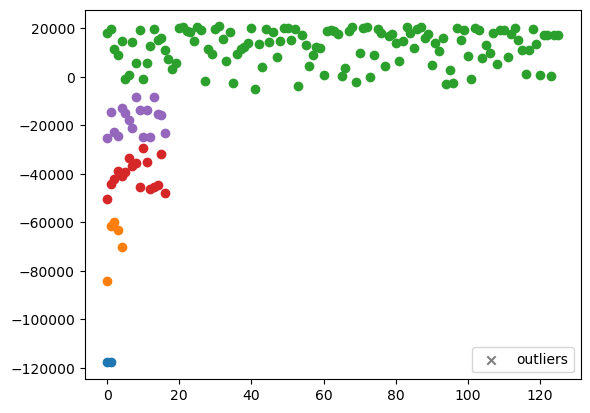

Reduced To:  2 , Number of Classes:  5 , Outliers:  2


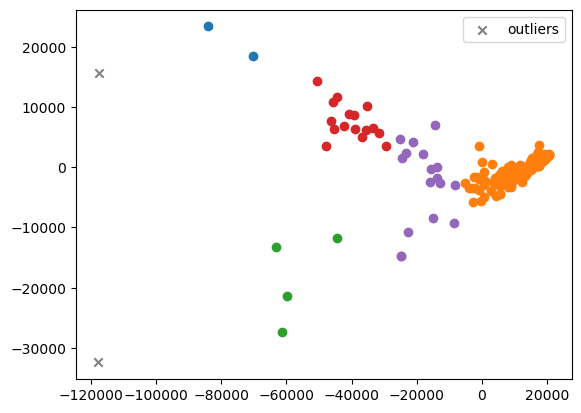

Reduced To:  3 , Number of Classes:  5 , Outliers:  2


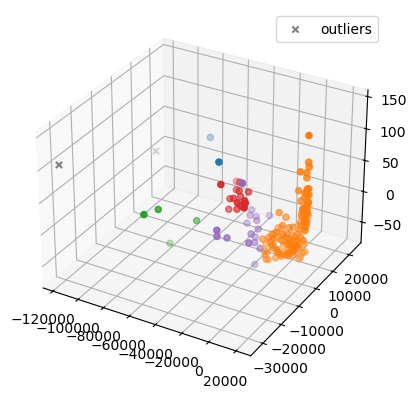

In [420]:
for t in range(3):
    pca = PCA(n_components=t+1)
    pca.fit(data)
    reduced_data = pca.transform(data)
    model = FuzzyEntropy()
    info, outliers =model.fit(reduced_data,B,y)
    print("Reduced To: ",reduced_data.shape[1],", Number of Classes: ",len(info), ", Outliers: ",len(outliers))
    f_data =show(info,outliers,dim=t+1)

